### Convolutional Neural Network & Computer Vision with Tensorflow

**Getting data**

In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

# for os interactions
import os

2025-03-11 19:40:10.069208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# setup paths to data directory
train_dir='10_food_classes_all_data/train'
test_dir='10_food_classes_all_data/test'

# getting the sub-dirs to get classnames
import pathlib
datadir = pathlib.Path(train_dir)
class_names=np.array(sorted([item.name for item in datadir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [3]:
# Pre-process the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# initializing ImageDataGenerator with augmentation
train_datagen_augmented=ImageDataGenerator(rescale = 1/255.0,
                                 rotation_range = 90, # amount of rotation (degrees)
                                 shear_range = 0.2, # amount of shear range
                                 zoom_range = 0.2, # amount of zoom
                                 width_shift_range = 0.2, # move image along x-axis
                                 height_shift_range = 0.3, # move image along y-axis
                                 horizontal_flip = True # flips image horizontally
                                 )
valid_datagen=ImageDataGenerator(rescale=1/255.0,)

train_data=train_datagen_augmented.flow_from_directory(directory=train_dir,
                                             batch_size=32, # mini batch size
                                             target_size=(224,224), # target size of images (h,w) 
                                             class_mode="categorical", # 'categorical' (default), 'binary',..
                                             seed = random_seed,
                                             shuffle=True 
                                             )

valid_data=valid_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode="categorical",
                                             seed = random_seed,
                                             shuffle=True 
                                             )


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [4]:
# creating a CNN model (baseline: tinyVGG)

@kr.saving.register_keras_serializable(package="tinyVGG")
class tinyVGG(kr.Model):
    def __init__(self,lr=0.001,metrics=['accuracy'],**kwargs):
        # calling constructor of kr.Model() class
        super().__init__(**kwargs)

        # defining model layers

        ### CONV-POOL 1
        self.cnn1 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='valid',
                                           input_shape=(224,224,3),name='conv_1')
        self.cnn2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,name='conv_2')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2,
                                               padding='valid',name='pool_1')
        
        ### CONV-POOL 2
        self.cnn3 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,name='conv_3')
        self.cnn4 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,name='conv_4')
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2,name='pool_2')

        ### FLATTEN
        self.flatten1 = tf.keras.layers.Flatten(name='flatten_1')

        ### output layer
        self.output_layer = tf.keras.layers.Dense(10,name='output_layer')


        # layers:
        self._layers = [self.cnn1, self.cnn2, self.pool1,
                       self.cnn3, self.cnn4, self.pool2,
                       self.flatten1,
                       self.output_layer
                       ]
        
        # activations
        self.activations = {
            'conv_1':'relu',
            'conv_2':'relu',
            'pool_1':None,
            'conv_3':'relu',
            'conv_4':'relu',
            'pool_2':None,
            'flatten_1':None,
            'output_layer':'softmax'
        }

        # outputs & tracking
        self.track_layer_output = False
        self.track_activation_output = False
        self.layer_outputs=[]
        self.activation_outputs=[]
        

        ### other hyperparams
        self.loss_fn = 'categorical_crossentropy',
        self.optimizer = kr.optimizers.Adam(learning_rate=lr)
        self.loss_metrics = metrics
        

        ### build the model
        self.build()

    
    def build(self):
        inputs=tf.keras.Input(shape=[224,224,3])
        x=self._layers[0](inputs)
        for layer in self._layers[1:]:
            x=layer(x)

    def compile(self):
        super().compile(optimizer=self.optimizer,loss=self.loss_fn,metrics=self.loss_metrics)
    
    def call(self,inputs):
        x = inputs
        layer_outputs=[]
        activation_outputs=[]

        for layer in self._layers:
            # forward pass and appending output of each layer and activation
            x = layer(x)
            
            if self.track_layer_output:
                layer_outputs.append(x)

            x = self.get_activation(layer_name=layer.name)(x)
            
            if self.track_activation_output:
                activation_outputs.append(x)

        self.layer_outputs=layer_outputs
        self.activation_outputs=activation_outputs

        output = x
        return output


    def get_activation(self,layer_name):
        activation_name = self.activations.get(layer_name,None)
        def activation(input):
            if activation_name == None:
                    return input
            else:
                function = getattr(tf.nn,activation_name,None)
                return input if function is None else function(input)
        return activation

In [5]:
model_1=tinyVGG(name='model_1')
model_1.track_layer_output=True
model_1.track_activation_output=True

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


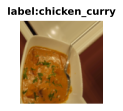

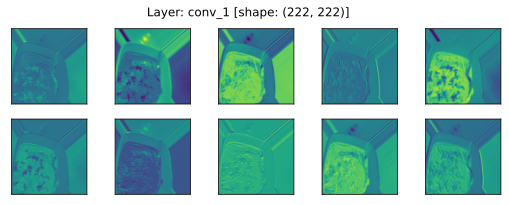

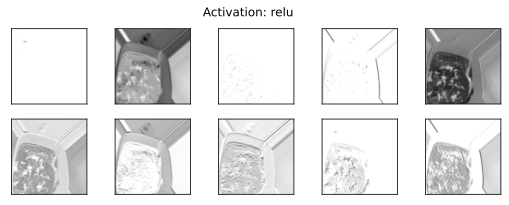

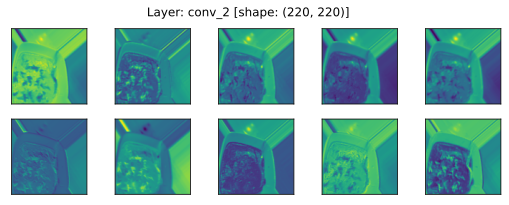

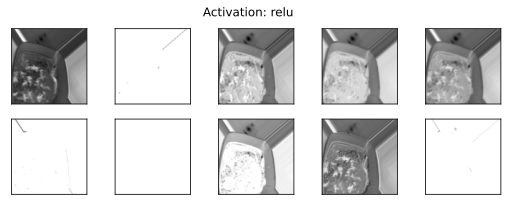

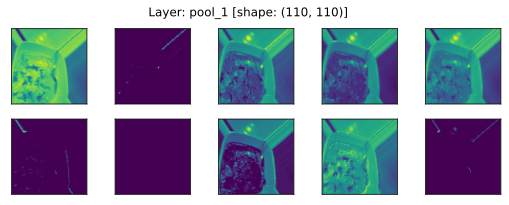

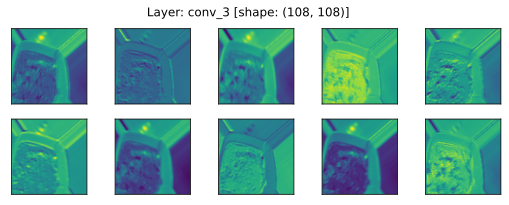

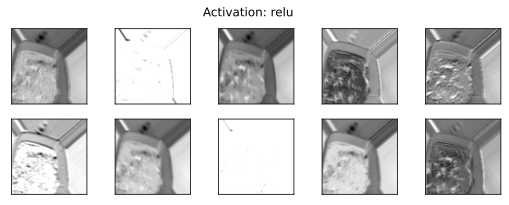

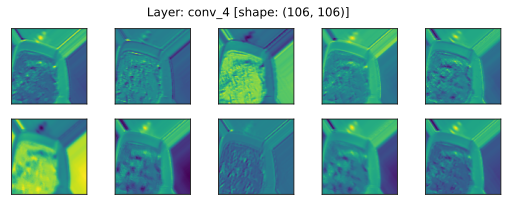

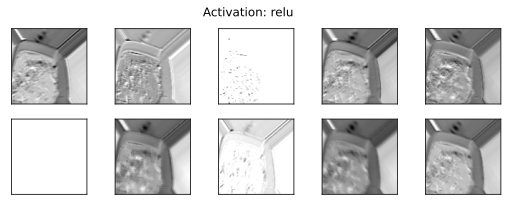

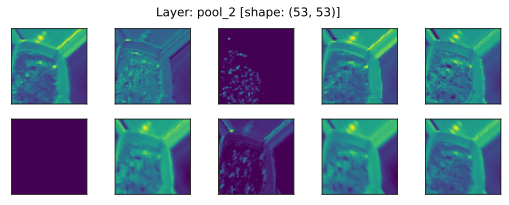

In [6]:
# visualizing before training
img_num = np.random.randint(0,32)
img_data,img_label=train_data.__next__()

img=tf.expand_dims(img_data[img_num],0)
model_1(img,training=False)

# visualizing each layer/activation output
plt.figure(figsize=(1.5,1.5))
plt.imshow(tf.squeeze(img))
plt.axis('off')
plt.title(f'label:{class_names[tf.argmax(img_label[img_num])]}',fontsize=10,fontweight='bold')
plt.show()

for i,(layer_o) in enumerate(model_1.layer_outputs[:-2]):
    ### layers
    layer_o=tf.squeeze(layer_o)
    fig,axs = plt.subplots(2,int(layer_o.shape[2]/2),figsize=(9,3))
    for l_i,ax in enumerate(axs.flatten()):
        ax.imshow(layer_o[:,:,l_i])
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(f'Layer: {model_1._layers[i].name} [shape: {layer_o[:,:,l_i].shape}]')


    if model_1.activations[model_1._layers[i].name]!=None:
        act_o=tf.squeeze(model_1.activation_outputs[i])
        fig,axs = plt.subplots(2,int(layer_o.shape[2]/2),figsize=(9,3))
        for l_i,ax in enumerate(axs.flatten()):
            ax.imshow(act_o[:,:,l_i],cmap='binary')
            ax.set_xticks([])
            ax.set_yticks([])
        fig.suptitle(f'Activation: {model_1.activations[model_1._layers[i].name]}')


In [7]:
model_1.track_layer_output=False
model_1.track_activation_output=False
model_1.compile()
model_1.summary(show_trainable=True)

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv_1 (Conv2D)             │ (None, 222, 222, 10)  │        280 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_2 (Conv2D)             │ (None, 220, 220, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_1 (MaxPooling2D)       │ (None, 110, 110, 10)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_3 (Conv2D)             │ (None, 108, 108, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_4 (Conv2D)             │ (None, 106, 106, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_2 (MaxPooling2D)       │ (None, 53, 53, 10)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 28090)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 10)            │    280,910 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 283,920 (1.08 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# fitting the model
history_1 = model_1.fit(train_data,
            epochs=10,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data)
            )

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 170s 720ms/step - accuracy: 0.1400 - loss: 2.3342 - val_accuracy: 0.2232 - val_loss: 2.1408
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 170s 723ms/step - accuracy: 0.2047 - loss: 2.1832 - val_accuracy: 0.2628 - val_loss: 2.0698
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 170s 724ms/step - accuracy: 0.2323 - loss: 2.1279 - val_accuracy: 0.3012 - val_loss: 1.9877
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 171s 726ms/step - accuracy: 0.2679 - loss: 2.0676 - val_accuracy: 0.3160 - val_loss: 1.9543
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 155s 659ms/step - accuracy: 0.2731 - loss: 2.0470 - val_accuracy: 0.3456 - val_loss: 1.8890
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 148s 628ms/step - accuracy: 0.2959 - loss: 2.0161 - val_accuracy: 0.3704 - val_loss: 1.8218
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 149s 635ms/step - accuracy: 0.3081 - loss: 1.9898 - val_accuracy: 0.3828 - val_loss: 1.7805
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 151s 640ms/step - accuracy: 0.3204 -

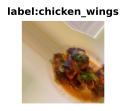

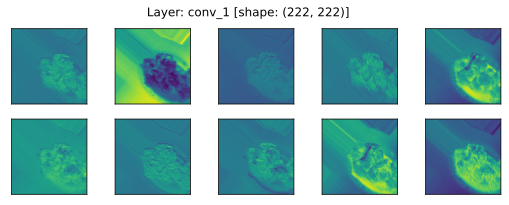

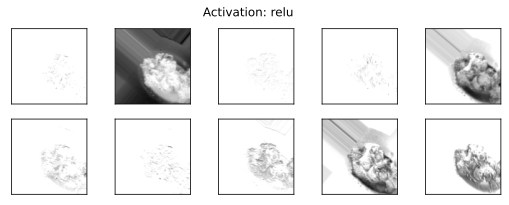

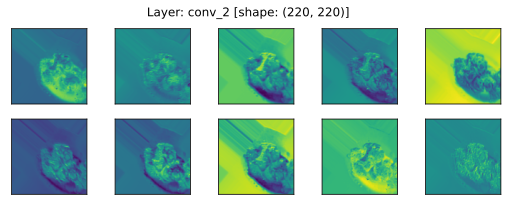

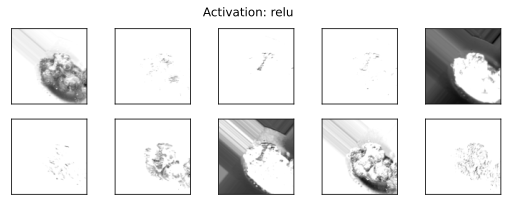

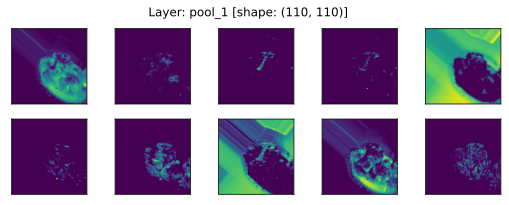

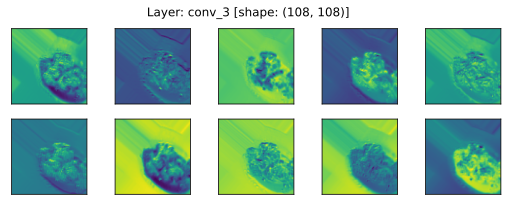

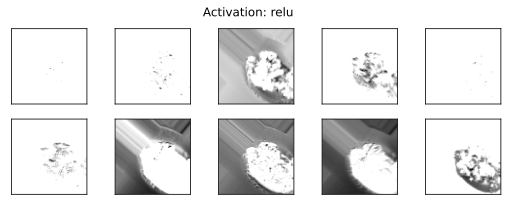

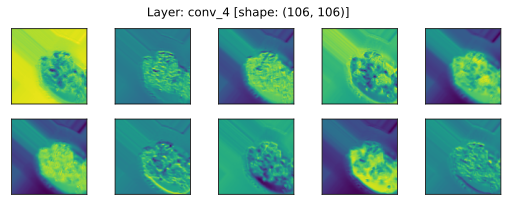

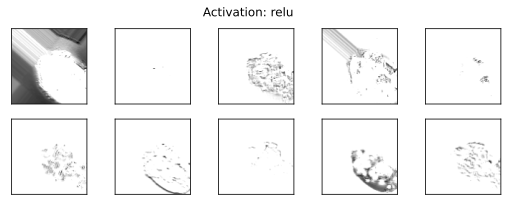

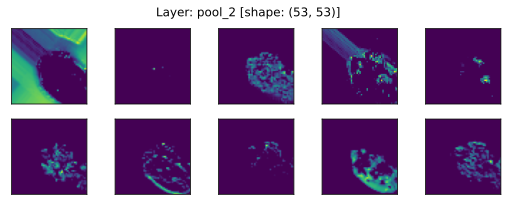

In [9]:
# visualizing after training
img_num = np.random.randint(0,32)
img_data,img_label=train_data.__next__()

model_1.track_activation_output=True
model_1.track_layer_output=True

img=tf.expand_dims(img_data[img_num],0)
model_1(img,training=False)

# visualizing each layer/activation output
plt.figure(figsize=(1.5,1.5))
plt.imshow(tf.squeeze(img))
plt.axis('off')
plt.title(f'label:{class_names[tf.argmax(img_label[img_num])]}',fontsize=10,fontweight='bold')
plt.show()

for i,(layer_o) in enumerate(model_1.layer_outputs[:-2]):
    ### layers
    layer_o=tf.squeeze(layer_o)
    fig,axs = plt.subplots(2,int(layer_o.shape[2]/2),figsize=(9,3))
    for l_i,ax in enumerate(axs.flatten()):
        ax.imshow(layer_o[:,:,l_i])
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(f'Layer: {model_1._layers[i].name} [shape: {layer_o[:,:,l_i].shape}]')


    if model_1.activations[model_1._layers[i].name]!=None:
        act_o=tf.squeeze(model_1.activation_outputs[i])
        fig,axs = plt.subplots(2,int(layer_o.shape[2]/2),figsize=(9,3))
        for l_i,ax in enumerate(axs.flatten()):
            ax.imshow(act_o[:,:,l_i],cmap='binary')
            ax.set_xticks([])
            ax.set_yticks([])
        fig.suptitle(f'Activation: {model_1.activations[model_1._layers[i].name]}')

In [10]:
# evaluating model
model_1.evaluate(valid_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.4465 - loss: 1.6595


[1.7075122594833374, 0.4323999881744385]

In [11]:
# plotting validation and training curves separately

def plot_loss_curves(history):
    # loss
    loss=history.history["loss"]
    val_loss=history.history['val_loss']

    # accuracy
    accuracy=tf.multiply(history.history['accuracy'],100)
    val_accuracy=tf.multiply(history.history['val_accuracy'],100)
    
    min_loss=tf.reduce_min(loss)
    min_val_loss=tf.reduce_min(val_loss)
    loc_loss=tf.argmin(loss)+1
    loc_val_loss=tf.argmin(val_loss)+1

    max_accuracy=tf.reduce_max(accuracy)
    max_val_accuracy=tf.reduce_max(val_accuracy)
    loc_acc=tf.argmax(accuracy)+1
    loc_val_acc=tf.argmax(val_accuracy)+1

    epochs = range(1,len(history.history["loss"])+1) # length of one of history object


    # plotting
    plt.figure()
    fig,axs=plt.subplots(1,2,figsize=(8,3))
    
    # loss
    axs[0].plot(epochs,loss,label=f'training loss (min:{min_loss:.2f})')
    axs[0].scatter(loc_loss,min_loss,s=30,color=(1,0,0))
    axs[0].plot(epochs,val_loss,label=f'validation loss (min:{min_val_loss:.2f})')
    axs[0].scatter(loc_val_loss,min_val_loss,s=30,color=(1,0,0))
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training & Validation')
    axs[0].legend()

    # accuracy
    axs[1].plot(epochs,accuracy,label=f'training accuracy (max:{max_accuracy:.2f}%)')
    axs[1].scatter(loc_acc,max_accuracy,s=30,color=(0,1,0))
    axs[1].plot(epochs,val_accuracy,label=f'validation accuracy (max:{max_val_accuracy:.2f}%)')
    axs[1].scatter(loc_val_acc,max_val_accuracy,s=30,color=(0,1,0))
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss/Accuracy')
    axs[1].set_title('Training & Validation')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

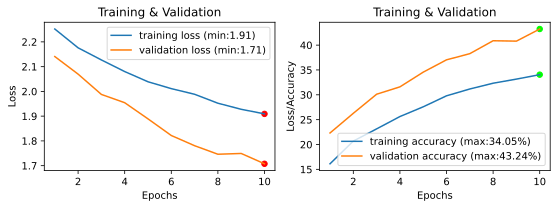

In [12]:
plot_loss_curves(history_1)

**observation**: 
* here we are getting validation accuracy better then training accuracy, it something like training someone on difficult questions, and when the same person is given easy question, it can be easily tackled

**8. Making a prediction with our trained model on custom data (multi-class)**

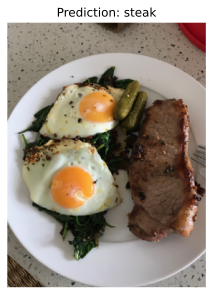

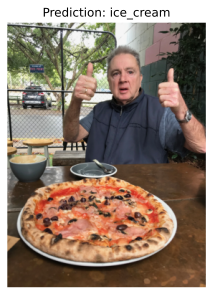

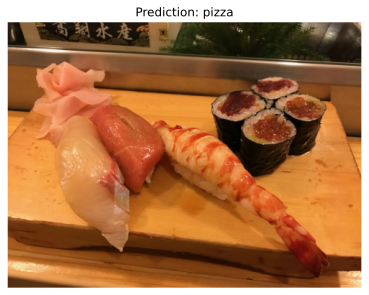

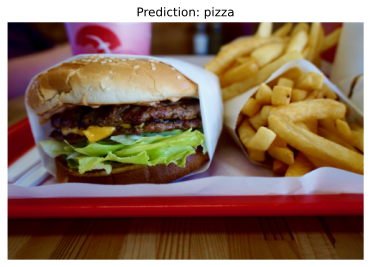

In [13]:
# load & pre-processing helper function
def load_preprocess(filename,shape=(224,224,3)):
    # load the image
    img=tf.io.read_file(filename=filename)
    img=tf.image.decode_image(img)
    
    # resize
    img=tf.image.resize(img,shape[:2])
    
    # rescale/normalize image
    img=img/255.0

    # expand dimensions
    img = tf.expand_dims(img,axis=0)

    return img

# predicting and plotting
def pred_plot(model,filename,class_names):
    img=load_preprocess(filename)
    prediction=class_names[tf.argmax(tf.squeeze(model.predict(img,verbose=0)))]  
    plt.imshow(tf.squeeze(plt.imread(filename)))
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show() 

pred_plot(model_1,'10_food_classes_all_data/custom_images/steak.jpeg',class_names) 

pred_plot(model_1,'10_food_classes_all_data/custom_images/pizza.jpeg',class_names) 

pred_plot(model_1,'10_food_classes_all_data/custom_images/sushi.jpeg',class_names) 

pred_plot(model_1,'10_food_classes_all_data/custom_images/hamburger.jpeg',class_names) 


**9. Saving and loading our model**

In [14]:
model_1.save('best_model.keras')

In [15]:
m=kr.models.load_model('best_model.keras')
m.summary()

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables wherea

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │       280,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,920 (1.08 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
m.compile()
m.evaluate(valid_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.4375 - loss: 1.7078


[1.7075116634368896, 0.4323999881744385]

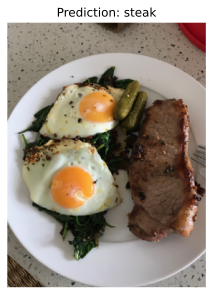

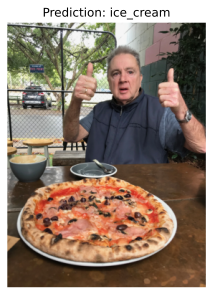

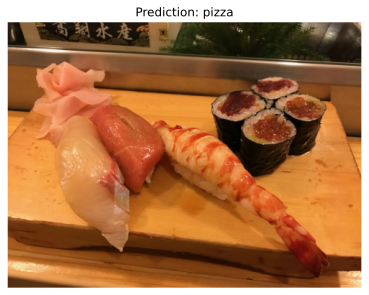

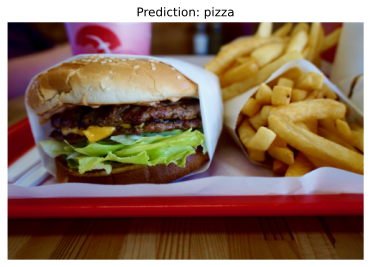

In [17]:
pred_plot(m,'10_food_classes_all_data/custom_images/steak.jpeg',class_names) 

pred_plot(m,'10_food_classes_all_data/custom_images/pizza.jpeg',class_names) 

pred_plot(m,'10_food_classes_all_data/custom_images/sushi.jpeg',class_names) 

pred_plot(m,'10_food_classes_all_data/custom_images/hamburger.jpeg',class_names) 


***-- CONTD IN NEXT NOTEBOOK --***